# Deep Kernel Learning with Flux

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/master/examples/2-deep-kernel-learning/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/2-deep-kernel-learning/).*

In [1]:
# Background

This example trains a GP whose inputs are passed through a neural network.
This kind of model has been considered previously [^Calandra] [^Wilson], although it has been shown that some care is needed to avoid substantial overfitting [^Ober].
In this example we make use of the `FunctionTransform` from [KernelFunctions.jl](github.com/JuliaGaussianProcesses/KernelFunctions.jl/) to put a simple Multi-Layer Perceptron built using Flux.jl inside a standard kernel.

[^Calandra]: Calandra, R., Peters, J., Rasmussen, C. E., & Deisenroth, M. P. (2016, July). [Manifold Gaussian processes for regression.](https://ieeexplore.ieee.org/abstract/document/7727626) In 2016 International Joint Conference on Neural Networks (IJCNN) (pp. 3338-3345). IEEE.

[^Wilson]: Wilson, A. G., Hu, Z., Salakhutdinov, R. R., & Xing, E. P. (2016). [Stochastic variational deep kernel learning.](https://proceedings.neurips.cc/paper/2016/hash/bcc0d400288793e8bdcd7c19a8ac0c2b-Abstract.html) Advances in Neural Information Processing Systems, 29.

[^Ober]: Ober, S. W., Rasmussen, C. E., & van der Wilk, M. (2021, December). [The promises and pitfalls of deep kernel learning.](https://proceedings.mlr.press/v161/ober21a.html) In Uncertainty in Artificial Intelligence (pp. 1206-1216). PMLR.

### Package loading
We use a couple of useful packages to plot and optimize
the different hyper-parameters

In [2]:
using AbstractGPs
using Distributions
using Flux
using KernelFunctions
using LinearAlgebra
using Plots
default(; legendfontsize=15.0, linewidth=3.0);

## Data creation
We create a simple 1D Problem with very different variations

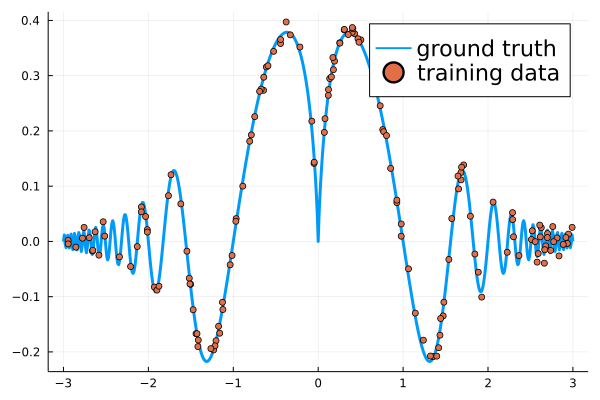

In [3]:
xmin, xmax = (-3, 3)  # Limits
N = 150
noise_std = 0.01
x_train_vec = rand(Uniform(xmin, xmax), N) # Training dataset
x_train = collect(eachrow(x_train_vec)) # vector-of-vectors for Flux compatibility
target_f(x) = sinc(abs(x)^abs(x)) # We use sinc with a highly varying value
y_train = target_f.(x_train_vec) + randn(N) * noise_std
x_test_vec = range(xmin, xmax; length=200) # Testing dataset
x_test = collect(eachrow(x_test_vec)) # vector-of-vectors for Flux compatibility

plot(xmin:0.01:xmax, target_f; label="ground truth")
scatter!(x_train_vec, y_train; label="training data")

## Model definition
We create a neural net with 2 layers and 10 units each.
The data is passed through the NN before being used in the kernel.

In [4]:
neuralnet = Chain(Dense(1, 20), Dense(20, 30), Dense(30, 5))

Chain(
  Dense(1 => 20),                       # 40 parameters
  Dense(20 => 30),                      # 630 parameters
  Dense(30 => 5),                       # 155 parameters
)                   # Total: 6 arrays, 825 parameters, 3.598 KiB.

We use the Squared Exponential Kernel:

In [5]:
k = SqExponentialKernel() ∘ FunctionTransform(neuralnet)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: Chain(Dense(1 => 20), Dense(20 => 30), Dense(30 => 5))

We now define our model:

In [6]:
gpprior = GP(k)  # GP Prior
fx = AbstractGPs.FiniteGP(gpprior, x_train, noise_std^2)  # Prior at the observations
fp = posterior(fx, y_train)  # Posterior of f given the observations

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.FunctionTransform{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.FunctionTransform{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{F

This computes the negative log evidence of `y` (the negative log marginal likelihood of
the neural network parameters), which is going to be used as the objective:

In [7]:
loss(y) = -logpdf(fx, y)

@info "Initial loss = $(loss(y_train))"

[ Info: Initial loss = 2739.1149319915908


Flux will automatically extract all the parameters of the kernel

In [8]:
ps = Flux.params(k)

Params([Float32[-0.30894244; 0.054902848; … ; 0.4832054; -0.47643146;;], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0018573804 0.3398745 … 0.33956718 -0.12084151; 0.13889223 0.26722318 … 0.3154729 0.2626244; … ; -0.34408152 -0.01782289 … 0.20777754 -0.31207043; -0.053920645 0.33943698 … -0.20652123 -0.17020424], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.13829304 0.31570977 … 0.21501398 0.2135998; 0.07852668 0.3071736 … -0.115531355 -0.30058014; … ; -0.29242083 0.03142631 … 0.30646172 0.025679339; -0.0039899484 0.18139714 … -0.40660772 0.4021376], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

We show the initial prediction with the untrained model

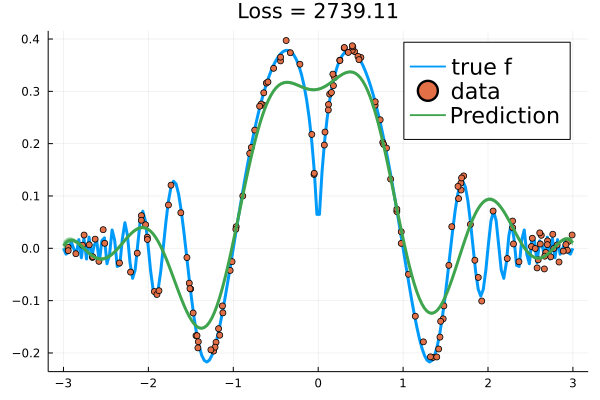

In [9]:
p_init = plot(; title="Loss = $(round(loss(y_train); sigdigits=6))")
plot!(vcat(x_test...), target_f; label="true f")
scatter!(vcat(x_train...), y_train; label="data")
pred_init = marginals(fp(x_test))
plot!(vcat(x_test...), mean.(pred_init); ribbon=std.(pred_init), label="Prediction")

## Training

[ Info: iteration 10/200: loss = 48.32068851683454
[ Info: iteration 20/200: loss = 23.45351116411198
[ Info: iteration 30/200: loss = -178.8437219984675
[ Info: iteration 40/200: loss = 84.776914556141
[ Info: iteration 50/200: loss = 102.21070344520746
[ Info: iteration 60/200: loss = 105.39914817595889
[ Info: iteration 70/200: loss = 105.9234597809893
[ Info: iteration 80/200: loss = 105.56713709406766
[ Info: iteration 90/200: loss = 104.82240045769865
[ Info: iteration 100/200: loss = 103.83903174965265
[ Info: iteration 110/200: loss = 102.6479054920172
[ Info: iteration 120/200: loss = 101.22806119742106
[ Info: iteration 130/200: loss = 99.52454162984685
[ Info: iteration 140/200: loss = 97.44436682559473
[ Info: iteration 150/200: loss = 94.8336471518162
[ Info: iteration 160/200: loss = 91.42027125269624
[ Info: iteration 170/200: loss = 86.66310245436381
[ Info: iteration 180/200: loss = 79.27019016829911
[ Info: iteration 190/200: loss = 65.00919901170029
[ Info: iteration

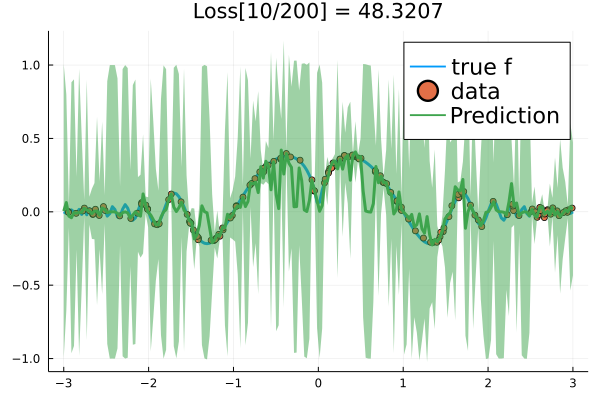

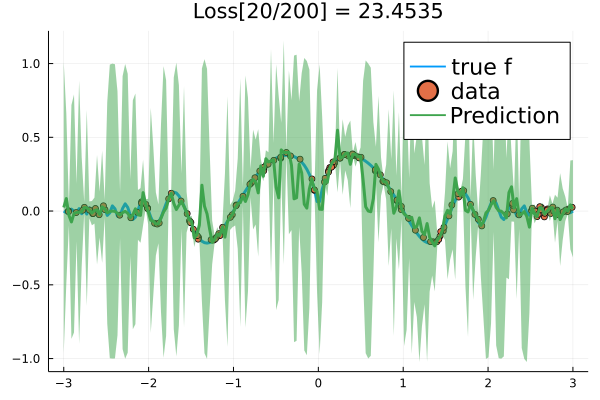

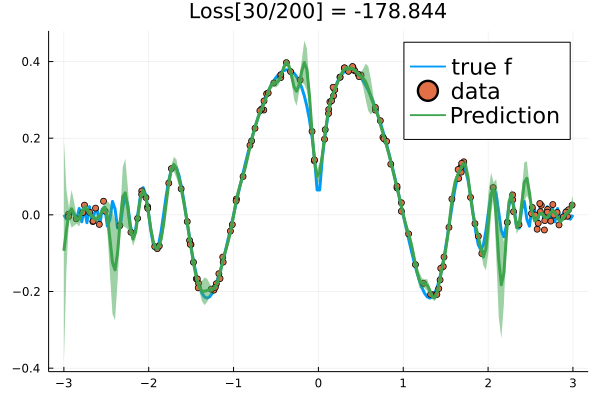

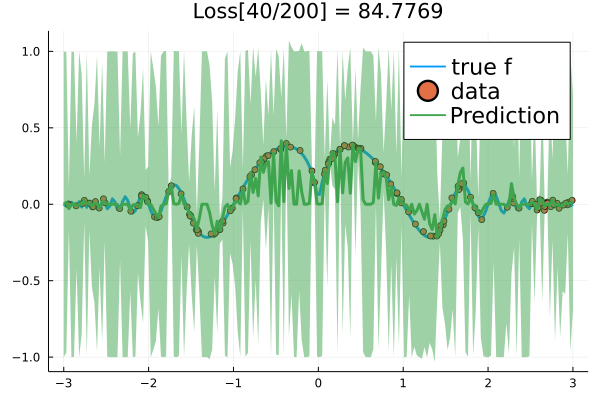

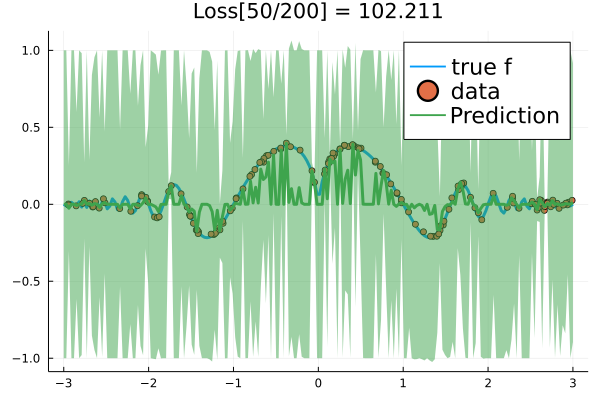

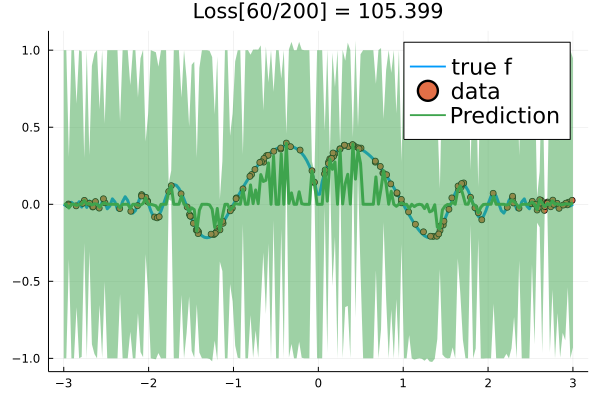

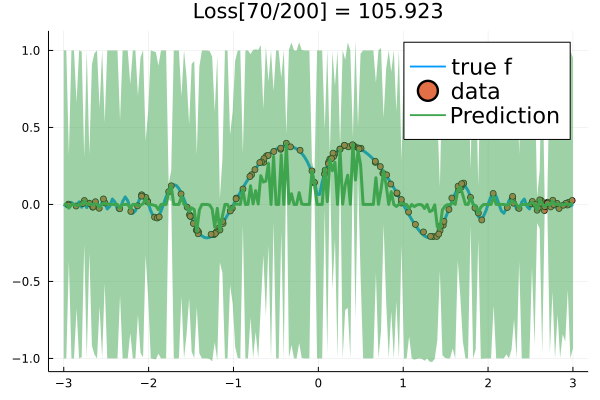

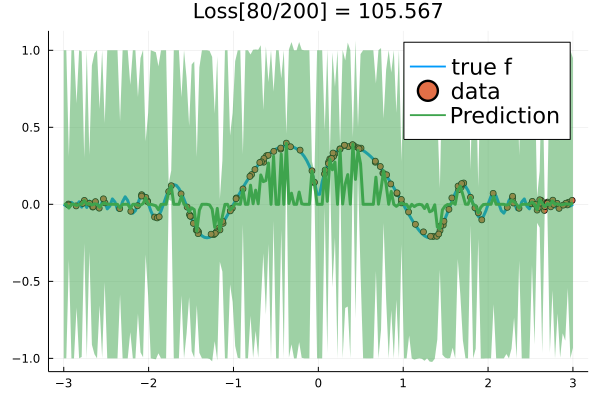

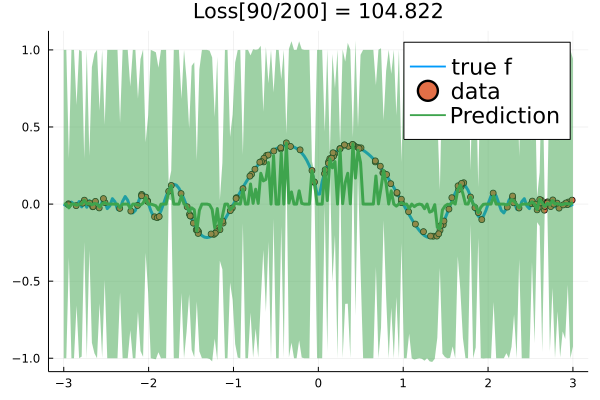

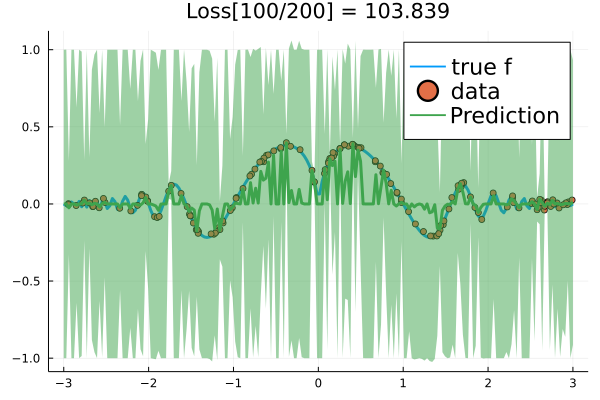

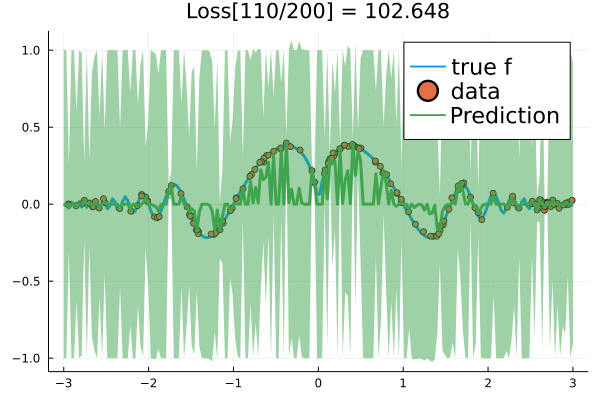

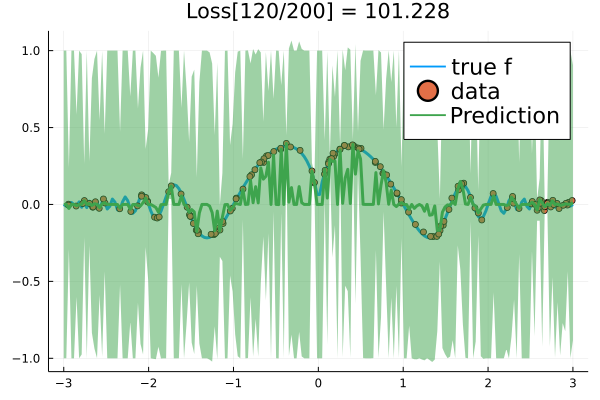

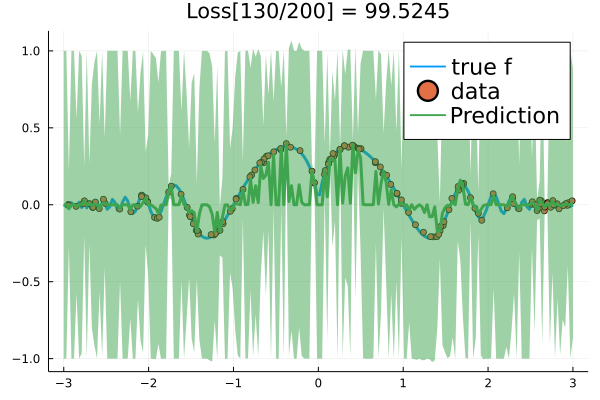

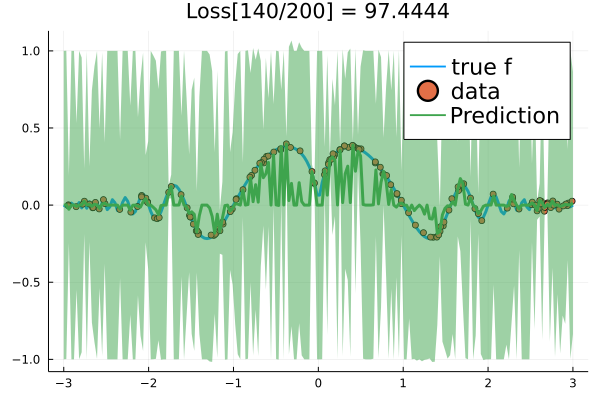

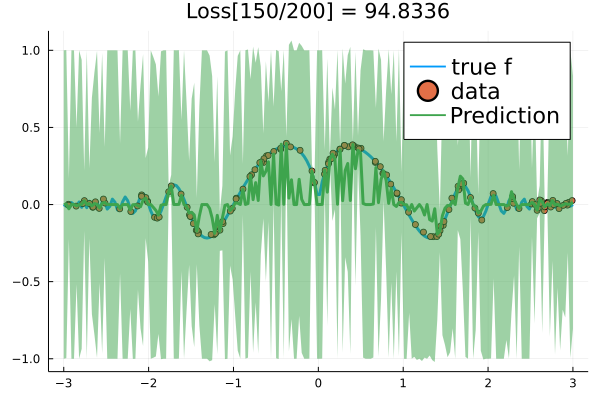

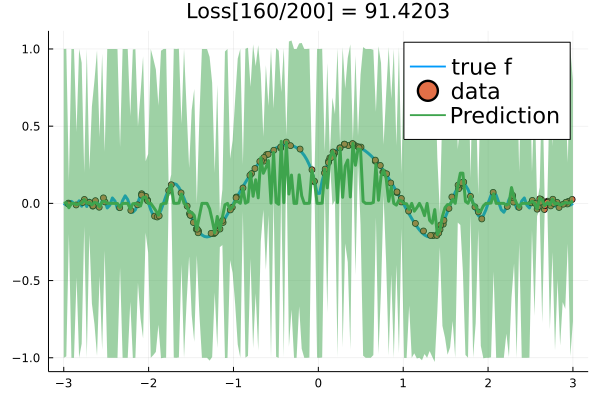

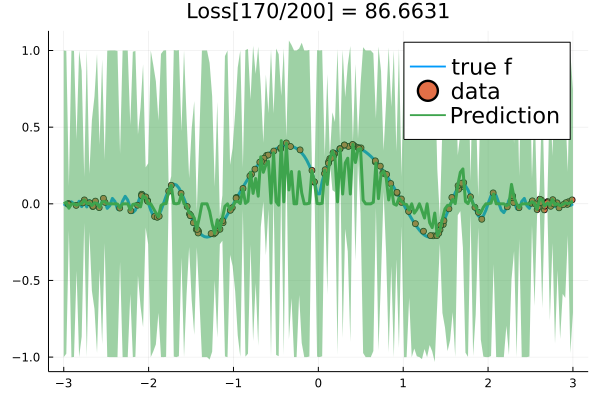

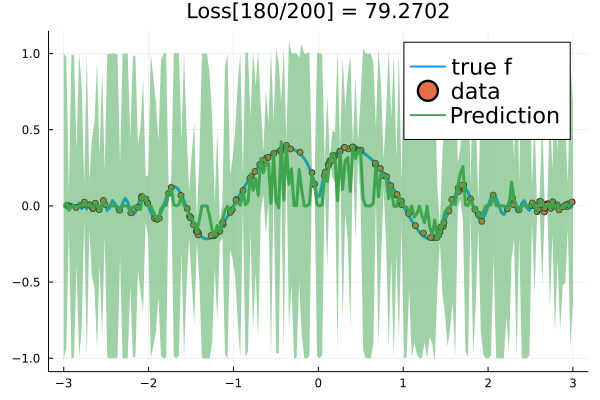

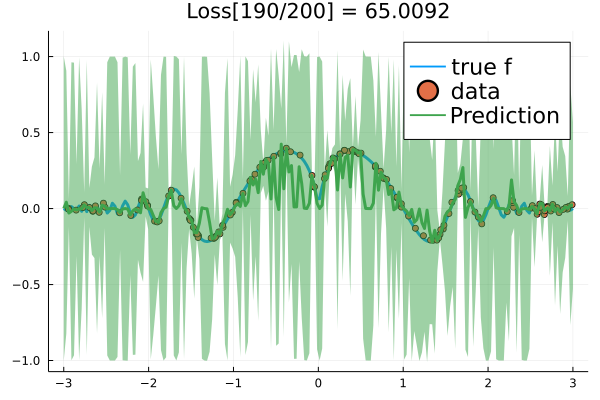

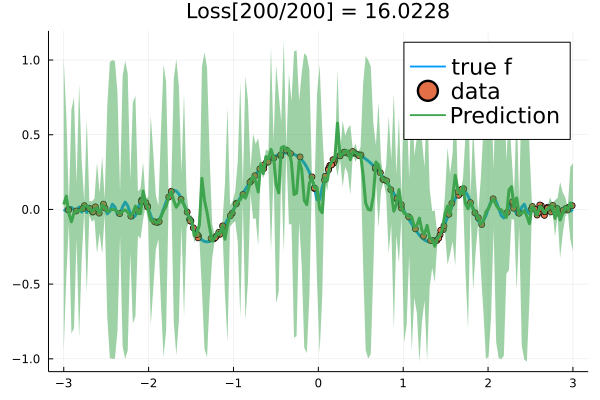

In [10]:
nmax = 200
opt = Flux.ADAM(0.1)

anim = Animation()
for i in 1:nmax
    grads = gradient(ps) do
        loss(y_train)
    end
    Flux.Optimise.update!(opt, ps, grads)

    if i % 10 == 0
        L = loss(y_train)
        @info "iteration $i/$nmax: loss = $L"

        p = plot(; title="Loss[$i/$nmax] = $(round(L; sigdigits=6))")
        plot!(vcat(x_test...), target_f; label="true f")
        scatter!(vcat(x_train...), y_train; label="data")
        pred = marginals(posterior(fx, y_train)(x_test))
        plot!(vcat(x_test...), mean.(pred); ribbon=std.(pred), label="Prediction")
        frame(anim)
        display(p)
    end
end
gif(anim, "train-dkl.gif"; fps=3)
nothing #hide

![](train-dkl.gif)
<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
      Status &#96;~/work/AbstractGPs.jl/AbstractGPs.jl/examples/2-deep-kernel-learning/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.13 &#96;/home/runner/work/AbstractGPs.jl/AbstractGPs.jl#448f826&#96;
  &#91;31c24e10&#93; Distributions v0.25.58
  &#91;587475ba&#93; Flux v0.13.1
  &#91;ec8451be&#93; KernelFunctions v0.10.38
  &#91;98b081ad&#93; Literate v2.13.2
  &#91;cc2ba9b6&#93; MLDataUtils v0.5.4
  &#91;91a5bcdd&#93; Plots v1.29.0
  &#91;e88e6eb3&#93; Zygote v0.6.40
  &#91;37e2e46d&#93; LinearAlgebra
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.7.2
Commit bf53498635 &#40;2022-02-06 15:21 UTC&#41;
Platform Info:
  OS: Linux &#40;x86_64-pc-linux-gnu&#41;
  CPU: Intel&#40;R&#41; Xeon&#40;R&#41; Platinum 8171M CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 &#40;ORCJIT, skylake-avx512&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/fsJ6N/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*